In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

C:\Users\21550\anaconda3\envs\pytorch_3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


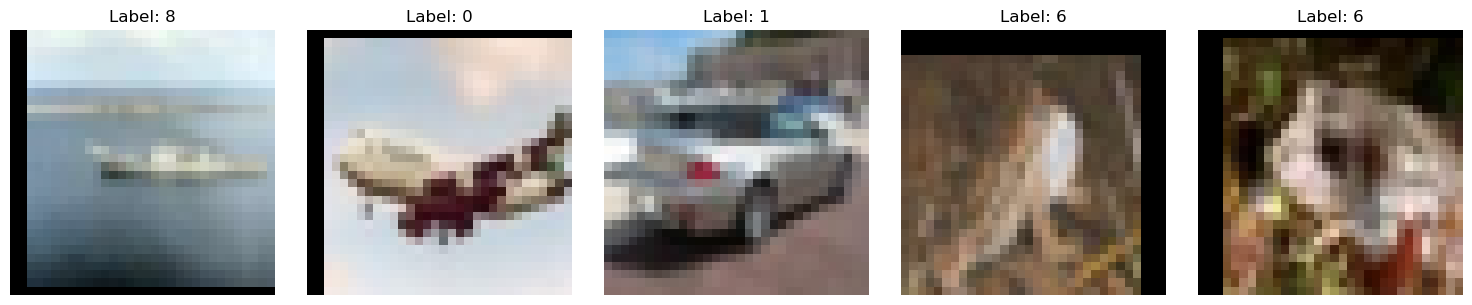

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
class ResNetSmallWide(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),  # 3→128
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Stage 1
            Residual(128, 128),
            Residual(128, 128),

            # Stage 2
            Residual(128, 256, use_1x1conv=True, strides=2),
            Residual(256, 256),

            # Stage 3
            Residual(256, 512, use_1x1conv=True, strides=2),
            Residual(512, 512),

            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)  # 末尾全连接也需对应修改
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmallWide().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001,weight_decay=0.0001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model_bigger.pth')

Epoch 1/100: 100%|██████████| 352/352 [01:02<00:00,  5.65it/s]


Epoch 1 => Train Loss: 1.5854, Acc: 0.4108 | Val Loss: 1.3295, Acc: 0.5296


Epoch 2/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 2 => Train Loss: 1.0663, Acc: 0.6177 | Val Loss: 1.1469, Acc: 0.6062


Epoch 3/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 3 => Train Loss: 0.8356, Acc: 0.7047 | Val Loss: 0.7183, Acc: 0.7540


Epoch 4/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 4 => Train Loss: 0.6747, Acc: 0.7625 | Val Loss: 0.5703, Acc: 0.8052


Epoch 5/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 5 => Train Loss: 0.5507, Acc: 0.8109 | Val Loss: 0.5377, Acc: 0.8184


Epoch 6/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 6 => Train Loss: 0.4739, Acc: 0.8357 | Val Loss: 0.6489, Acc: 0.7900


Epoch 7/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 7 => Train Loss: 0.4117, Acc: 0.8562 | Val Loss: 0.4613, Acc: 0.8464


Epoch 8/100: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s]


Epoch 8 => Train Loss: 0.3654, Acc: 0.8727 | Val Loss: 0.4065, Acc: 0.8644


Epoch 9/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 9 => Train Loss: 0.3290, Acc: 0.8852 | Val Loss: 0.3900, Acc: 0.8634


Epoch 10/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 10 => Train Loss: 0.2927, Acc: 0.8956 | Val Loss: 0.3773, Acc: 0.8768


Epoch 11/100: 100%|██████████| 352/352 [01:00<00:00,  5.85it/s]


Epoch 11 => Train Loss: 0.2623, Acc: 0.9094 | Val Loss: 0.4162, Acc: 0.8716


Epoch 12/100: 100%|██████████| 352/352 [01:00<00:00,  5.84it/s]


Epoch 12 => Train Loss: 0.2390, Acc: 0.9177 | Val Loss: 0.3781, Acc: 0.8784


Epoch 13/100: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s]


Epoch 13 => Train Loss: 0.2190, Acc: 0.9248 | Val Loss: 0.3843, Acc: 0.8848


Epoch 14/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 14 => Train Loss: 0.2031, Acc: 0.9290 | Val Loss: 0.3338, Acc: 0.8932


Epoch 15/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 15 => Train Loss: 0.1792, Acc: 0.9377 | Val Loss: 0.3510, Acc: 0.8932


Epoch 16/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 16 => Train Loss: 0.1665, Acc: 0.9410 | Val Loss: 0.3193, Acc: 0.8990


Epoch 17/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 17 => Train Loss: 0.1517, Acc: 0.9467 | Val Loss: 0.3286, Acc: 0.9054


Epoch 18/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 18 => Train Loss: 0.1344, Acc: 0.9523 | Val Loss: 0.3437, Acc: 0.9020


Epoch 19/100: 100%|██████████| 352/352 [01:00<00:00,  5.78it/s]


Epoch 19 => Train Loss: 0.1250, Acc: 0.9558 | Val Loss: 0.3330, Acc: 0.9086


Epoch 20/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 20 => Train Loss: 0.1193, Acc: 0.9578 | Val Loss: 0.3515, Acc: 0.9032


Epoch 21/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 21 => Train Loss: 0.1124, Acc: 0.9605 | Val Loss: 0.3478, Acc: 0.9046


Epoch 22/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 22 => Train Loss: 0.0959, Acc: 0.9659 | Val Loss: 0.3500, Acc: 0.9056


Epoch 23/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 23 => Train Loss: 0.0984, Acc: 0.9647 | Val Loss: 0.3619, Acc: 0.9046


Epoch 24/100: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s]


Epoch 24 => Train Loss: 0.0906, Acc: 0.9682 | Val Loss: 0.3642, Acc: 0.9074


Epoch 25/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 25 => Train Loss: 0.0834, Acc: 0.9713 | Val Loss: 0.3542, Acc: 0.9098


Epoch 26/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 26 => Train Loss: 0.0757, Acc: 0.9732 | Val Loss: 0.3755, Acc: 0.9056


Epoch 27/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 27 => Train Loss: 0.0774, Acc: 0.9723 | Val Loss: 0.3555, Acc: 0.9122


Epoch 28/100: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s]


Epoch 28 => Train Loss: 0.0704, Acc: 0.9754 | Val Loss: 0.3735, Acc: 0.9098


Epoch 29/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 29 => Train Loss: 0.0620, Acc: 0.9794 | Val Loss: 0.3404, Acc: 0.9170


Epoch 30/100: 100%|██████████| 352/352 [01:00<00:00,  5.80it/s]


Epoch 30 => Train Loss: 0.0653, Acc: 0.9778 | Val Loss: 0.3875, Acc: 0.9104


Epoch 31/100: 100%|██████████| 352/352 [01:00<00:00,  5.82it/s]


Epoch 31 => Train Loss: 0.0662, Acc: 0.9762 | Val Loss: 0.3487, Acc: 0.9172


Epoch 32/100: 100%|██████████| 352/352 [01:00<00:00,  5.81it/s]


Epoch 32 => Train Loss: 0.0545, Acc: 0.9806 | Val Loss: 0.3746, Acc: 0.9134


Epoch 33/100: 100%|██████████| 352/352 [01:00<00:00,  5.85it/s]


Epoch 33 => Train Loss: 0.0564, Acc: 0.9807 | Val Loss: 0.4234, Acc: 0.9058


Epoch 34/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 34 => Train Loss: 0.0532, Acc: 0.9815 | Val Loss: 0.4257, Acc: 0.9072


Epoch 35/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 35 => Train Loss: 0.0538, Acc: 0.9816 | Val Loss: 0.4240, Acc: 0.9084


Epoch 36/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 36 => Train Loss: 0.0512, Acc: 0.9819 | Val Loss: 0.4100, Acc: 0.9148


Epoch 37/100: 100%|██████████| 352/352 [00:59<00:00,  5.87it/s]


Epoch 37 => Train Loss: 0.0458, Acc: 0.9841 | Val Loss: 0.3768, Acc: 0.9146


Epoch 38/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 38 => Train Loss: 0.0463, Acc: 0.9842 | Val Loss: 0.3690, Acc: 0.9172


Epoch 39/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 39 => Train Loss: 0.0400, Acc: 0.9864 | Val Loss: 0.3719, Acc: 0.9178


Epoch 40/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 40 => Train Loss: 0.0410, Acc: 0.9858 | Val Loss: 0.4543, Acc: 0.9114


Epoch 41/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 41 => Train Loss: 0.0454, Acc: 0.9844 | Val Loss: 0.3963, Acc: 0.9126


Epoch 42/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 42 => Train Loss: 0.0425, Acc: 0.9847 | Val Loss: 0.3945, Acc: 0.9170


Epoch 43/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 43 => Train Loss: 0.0377, Acc: 0.9868 | Val Loss: 0.4151, Acc: 0.9186


Epoch 44/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 44 => Train Loss: 0.0370, Acc: 0.9867 | Val Loss: 0.4503, Acc: 0.9064


Epoch 45/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 45 => Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.4271, Acc: 0.9172


Epoch 46/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 46 => Train Loss: 0.0394, Acc: 0.9860 | Val Loss: 0.4541, Acc: 0.9158


Epoch 47/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 47 => Train Loss: 0.0403, Acc: 0.9870 | Val Loss: 0.4067, Acc: 0.9172


Epoch 48/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 48 => Train Loss: 0.0337, Acc: 0.9884 | Val Loss: 0.4345, Acc: 0.9178


Epoch 49/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 49 => Train Loss: 0.0353, Acc: 0.9875 | Val Loss: 0.3947, Acc: 0.9192


Epoch 50/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 50 => Train Loss: 0.0301, Acc: 0.9897 | Val Loss: 0.3947, Acc: 0.9218


Epoch 51/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 51 => Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.4275, Acc: 0.9154


Epoch 52/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 52 => Train Loss: 0.0356, Acc: 0.9875 | Val Loss: 0.4402, Acc: 0.9128


Epoch 53/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 53 => Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.4026, Acc: 0.9220


Epoch 54/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 54 => Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.4336, Acc: 0.9184


Epoch 55/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 55 => Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.3904, Acc: 0.9254


Epoch 56/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 56 => Train Loss: 0.0305, Acc: 0.9894 | Val Loss: 0.4355, Acc: 0.9204


Epoch 57/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 57 => Train Loss: 0.0295, Acc: 0.9898 | Val Loss: 0.4261, Acc: 0.9196


Epoch 58/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 58 => Train Loss: 0.0303, Acc: 0.9897 | Val Loss: 0.4460, Acc: 0.9244


Epoch 59/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 59 => Train Loss: 0.0261, Acc: 0.9906 | Val Loss: 0.4319, Acc: 0.9194


Epoch 60/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 60 => Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.4489, Acc: 0.9168


Epoch 61/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 61 => Train Loss: 0.0315, Acc: 0.9887 | Val Loss: 0.4152, Acc: 0.9156


Epoch 62/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 62 => Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.4521, Acc: 0.9232


Epoch 63/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 63 => Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.4237, Acc: 0.9196


Epoch 64/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 64 => Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.4340, Acc: 0.9212


Epoch 65/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 65 => Train Loss: 0.0237, Acc: 0.9916 | Val Loss: 0.4453, Acc: 0.9204


Epoch 66/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 66 => Train Loss: 0.0248, Acc: 0.9913 | Val Loss: 0.4820, Acc: 0.9182


Epoch 67/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 67 => Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.4328, Acc: 0.9218


Epoch 68/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 68 => Train Loss: 0.0242, Acc: 0.9915 | Val Loss: 0.4039, Acc: 0.9232


Epoch 69/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 69 => Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.4384, Acc: 0.9244


Epoch 70/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 70 => Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.4796, Acc: 0.9176


Epoch 71/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 71 => Train Loss: 0.0264, Acc: 0.9903 | Val Loss: 0.4502, Acc: 0.9166


Epoch 72/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 72 => Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.4095, Acc: 0.9262


Epoch 73/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 73 => Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.4535, Acc: 0.9178


Epoch 74/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 74 => Train Loss: 0.0216, Acc: 0.9926 | Val Loss: 0.4731, Acc: 0.9202


Epoch 75/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 75 => Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.5100, Acc: 0.9138


Epoch 76/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 76 => Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.4536, Acc: 0.9224


Epoch 77/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 77 => Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.4199, Acc: 0.9268


Epoch 78/100: 100%|██████████| 352/352 [00:59<00:00,  5.91it/s]


Epoch 78 => Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.4277, Acc: 0.9288


Epoch 79/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 79 => Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.4563, Acc: 0.9234


Epoch 80/100: 100%|██████████| 352/352 [00:59<00:00,  5.88it/s]


Epoch 80 => Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.4644, Acc: 0.9198


Epoch 81/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 81 => Train Loss: 0.0182, Acc: 0.9937 | Val Loss: 0.5000, Acc: 0.9130


Epoch 82/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 82 => Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.4293, Acc: 0.9250


Epoch 83/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 83 => Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.4497, Acc: 0.9266


Epoch 84/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 84 => Train Loss: 0.0178, Acc: 0.9936 | Val Loss: 0.5144, Acc: 0.9156


Epoch 85/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 85 => Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.4726, Acc: 0.9222


Epoch 86/100: 100%|██████████| 352/352 [00:59<00:00,  5.91it/s]


Epoch 86 => Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.4320, Acc: 0.9248


Epoch 87/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 87 => Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.4366, Acc: 0.9238


Epoch 88/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 88 => Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.4423, Acc: 0.9190


Epoch 89/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 89 => Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.4739, Acc: 0.9200


Epoch 90/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 90 => Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.4740, Acc: 0.9246


Epoch 91/100: 100%|██████████| 352/352 [00:59<00:00,  5.91it/s]


Epoch 91 => Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.4638, Acc: 0.9248


Epoch 92/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 92 => Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.4221, Acc: 0.9242


Epoch 93/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 93 => Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.4439, Acc: 0.9250


Epoch 94/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 94 => Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.4525, Acc: 0.9262


Epoch 95/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 95 => Train Loss: 0.0181, Acc: 0.9935 | Val Loss: 0.4973, Acc: 0.9168


Epoch 96/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 96 => Train Loss: 0.0174, Acc: 0.9939 | Val Loss: 0.4031, Acc: 0.9272


Epoch 97/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 97 => Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.4583, Acc: 0.9252


Epoch 98/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 98 => Train Loss: 0.0152, Acc: 0.9948 | Val Loss: 0.4973, Acc: 0.9216


Epoch 99/100: 100%|██████████| 352/352 [00:59<00:00,  5.90it/s]


Epoch 99 => Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.4786, Acc: 0.9242


Epoch 100/100: 100%|██████████| 352/352 [00:59<00:00,  5.89it/s]


Epoch 100 => Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.4504, Acc: 0.9296


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies)) 

# 保存为 txt 文件，添加列名
np.savetxt("adamW_large.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

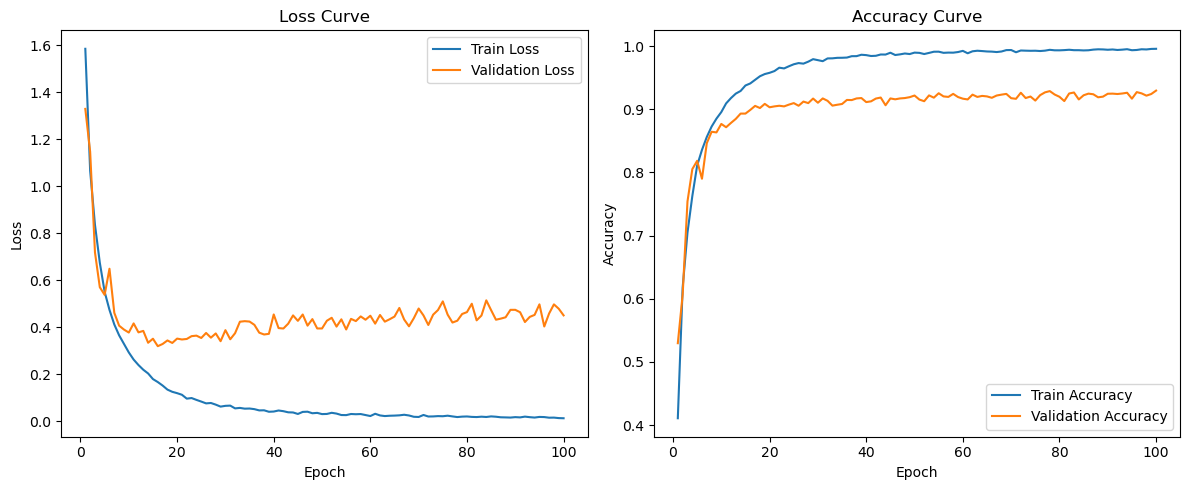

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [16]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.42%


In [17]:
model2 = ResNetSmallWide(num_classes=10)
model2.load_state_dict(torch.load('best_model_bigger.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 92.42%
